考虑 ATR10 / ATR60. 因为与短期高点有显著正相关。

last_top，原因同上

使用斯皮尔曼相关系数

是否应该允许同一高点多次突破？

In [1]:
from analysis_utils import *
from utils import date_to_milliseconds
pd.set_option('display.max_columns', None)

<Figure size 1000x500 with 0 Axes>

In [70]:
usd_name = 'TUSD'
token_name = 'BTC'
is_futures = False
symbol = token_name + usd_name
sim_data = get_combined_data(symbol, '+0_5-3atr10_bias0_1', 1680713040000, 1686713039999, is_futures, confirm_step=3)
sim_data_info = read_data(symbol, '+0_5-3atr10_bias0_1', 1680713040000, 1686713039999, is_futures)
print(f"data length = {len(sim_data)}")

buy_p    = sim_data_info.buy_points
sell_p   = sim_data_info.sell_points

sim_data['buy_price'] = np.nan
sim_data['sell_price'] = np.nan

j = 0
for i in range(len(sim_data)):
    if sim_data['open_time'][i] == buy_p.idx[j]:
        # Record these info on the preview step of the actually traded step
        idx = sim_data.index[i]-1
        sim_data.loc[idx, 'buy_price'] = buy_p.value[j]
        sim_data.loc[idx, 'hold_step'] = (sell_p.idx[j] - buy_p.idx[j]) // 60000
        sim_data.loc[idx, 'sell_price'] = sell_p.value[j]
        sim_data.loc[idx, 'earn'] = (sell_p.value[j] - buy_p.value[j]) / buy_p.value[j]
        
        j += 1
        if j >= len(sell_p.idx):
            break

# sim_data[sim_data['buy_price'].isnull() == False].head()

data length = 100000


In [71]:
total_num = sum(sim_data['buy_price'].isnull() == False)
print(f"Total: {total_num}")
earn_num = sum(sim_data['earn'] > 0)
print(f"Earn rate: {earn_num / total_num * 100 :.2f}%")
print(f"Average earn: {sim_data[sim_data['buy_price'].isnull() == False]['earn'].mean() * 100 :.4f}%")

Total: 4116
Earn rate: 87.10%
Average earn: 0.0041%


In [72]:
target = Target(target_step=3, steps=[3])
full_data = FeatData(sim_data, target)

# Drop useless features
full_data.drop_features(
   ['close_time', 'volume', 'taker_buy_volume', 'open_time', 'buy_price', 'sell_price'])

full_data.set_features_type(['hold_step'], FeatTypes.OTHERS)
full_data.set_features_type(['earn'], FeatTypes.TARGET)
full_data.add_feature('is_earn', FeatTypes.TARGET, lambda df: df['earn'].apply(lambda x: 1 if x > 0 else 0))

full_data.add_feature('max_after_top', FeatTypes.TARGET, lambda df: 
                      (df['high'].rolling(3).max().shift(-3) - df['last_top']) / df['close']) # / df['close']  
full_data.add_feature('min_after_top', FeatTypes.TARGET, lambda df: 
                      (df['low'].rolling(2).min().shift(-3) - df['last_top']) / df['close'])  

full_data.add_feature('TR', FeatTypes.TR, lambda df: df['high'] - df['low'] + 0.001)   # Incase TR is 0
full_data.add_feature('ER', FeatTypes.OTHERS, lambda df: (df['close'] - df['open']) / df['TR'])

full_data.add_feature('lastlast_top', FeatTypes.PRICE, lambda df: df['last_top'].shift(1))

def add_ll_bottom(df: pd.DataFrame):
   col = df['last_bottom'].shift(1)
   down_idx = df[df['is_up'] == 0].index
   col.loc[down_idx] = df['last_bottom']
   return col

full_data.add_feature('lastlast_bottom', FeatTypes.PRICE, lambda df: add_ll_bottom(df))

# 单位波动的成交额 -> 无效
# full_data.add_feature('volume/TR', FeatTypes.VOL_TR, lambda df: df['quote_assert_volume'] * df['close'] / df['TR'])
full_data.drop_features(['quote_assert_volume', 'taker_buy_quote_asset_volume'])

# Add features
add_ave_features(full_data, cycles = [3, 10, 60, 300], feat_names=['close', 'TR'])
add_ave_features(full_data, cycles = [3, 10, 60, 300], feat_names=['ER'], new_ave_of_base={'AER': ['ER', FeatTypes.OTHERS]})

fast_period = 10 
slow_period = 60
signal_period = 30
# add_macd(full_data, 'close', FeatTypes.DPRICE, fast_period, slow_period, signal_period)
# add_macd(full_data, 'TR', FeatTypes.TR, fast_period, slow_period, signal_period)

# Standardization
full_data.std()

# Drop na at last
full_data.drop_na()

full_data.df.head()

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,hold_step,earn,earn_after_3,is_earn,max_after_top,min_after_top,ER,lastlast_top,lastlast_bottom,MA3,MA10,MA60,MA300,ATR3,ATR10,ATR60,ATR300,AER3,AER10,AER60,AER300
308,0.999625,1.000095,0.999625,0.000470,1.000111,3.0,0.999065,5.0,0.0,2.0,0.0,0.000222,0.000473,1,0.000694,0.000256,0.798278,1.001589,0.999065,0.999787,0.999876,1.000600,0.998485,0.000420,0.000443,0.000532,0.000769,-0.059068,-0.045474,0.016830,0.021560
348,1.000175,1.000176,0.999790,0.000386,1.000646,8.0,0.999842,11.0,0.0,3.0,1.0,0.000198,0.000080,1,0.000210,-0.000726,-0.454336,1.000646,0.999842,1.000023,1.000211,1.000882,1.000074,0.000309,0.000394,0.000507,0.000721,-0.171409,-0.044804,-0.002931,0.002948
354,0.999455,1.000123,0.999396,0.000726,1.000246,4.0,0.999181,6.0,0.0,2.0,1.0,0.000236,0.001051,1,0.000917,-0.000112,0.750086,1.000246,0.999181,0.999625,0.999630,1.000141,0.999514,0.000477,0.000470,0.000512,0.000715,0.249860,0.075263,0.016527,0.012034
367,1.000084,1.000186,0.999882,0.000304,1.000315,4.0,0.998192,15.0,0.0,11.0,0.0,0.000205,0.001540,1,0.001650,0.000180,-0.275026,1.000315,0.998192,1.000043,1.000070,0.999228,0.998689,0.000302,0.000409,0.000518,0.000696,0.039233,0.100199,0.073933,0.020512
388,0.999757,1.000129,0.999607,0.000522,1.000132,7.0,0.999588,5.0,1.0,2.0,4.0,0.000229,-0.000089,1,0.000039,-0.000423,0.465955,1.000132,0.999588,0.999832,0.999783,0.999930,0.999640,0.000589,0.000457,0.000514,0.000696,0.013254,0.069494,0.034584,0.018517


In [50]:
price_feats  = set(full_data.cols_of_features([FeatTypes.PRICE]))
dprice_feats = set(full_data.cols_of_features([FeatTypes.DPRICE]))
tr_feats     = set(full_data.cols_of_features([FeatTypes.TR]))
vol_feats    = set(full_data.cols_of_features([FeatTypes.VOLUME]))
voltr_feats  = set(full_data.cols_of_features([FeatTypes.VOL_TR]))
tn_feats     = set(full_data.cols_of_features([FeatTypes.TRADE_NUM]))
print(f"price_feats: {price_feats}\n\
        dprice_feats: {dprice_feats}\n\
        tr_feats: {tr_feats}\n\
        vol_feats: {vol_feats}\n\
        voltr_feats: {voltr_feats}\n\
        tn_feats: {tn_feats}")
print(f"{set(full_data.df.columns) - price_feats - dprice_feats - tr_feats - vol_feats - tn_feats}")

price_feats: {'lastlast_bottom', 'high', 'last_bottom', 'low', 'MA10', 'MA3', 'MA300', 'lastlast_top', 'MA60', 'last_top', 'open'}
        dprice_feats: set()
        tr_feats: {'TR', 'ATR3', 'ATR300', 'ATR60', 'ATR10'}
        vol_feats: set()
        voltr_feats: set()
        tn_feats: set()
{'step_after_bottom', 'AER3', 'AER60', 'is_earn', 'AER10', 'max_after_top', 'is_up', 'min_after_top', 'ER', 'hold_step', 'cycle_step', 'step_after_top', 'earn', 'AER300', 'earn_after_3'}


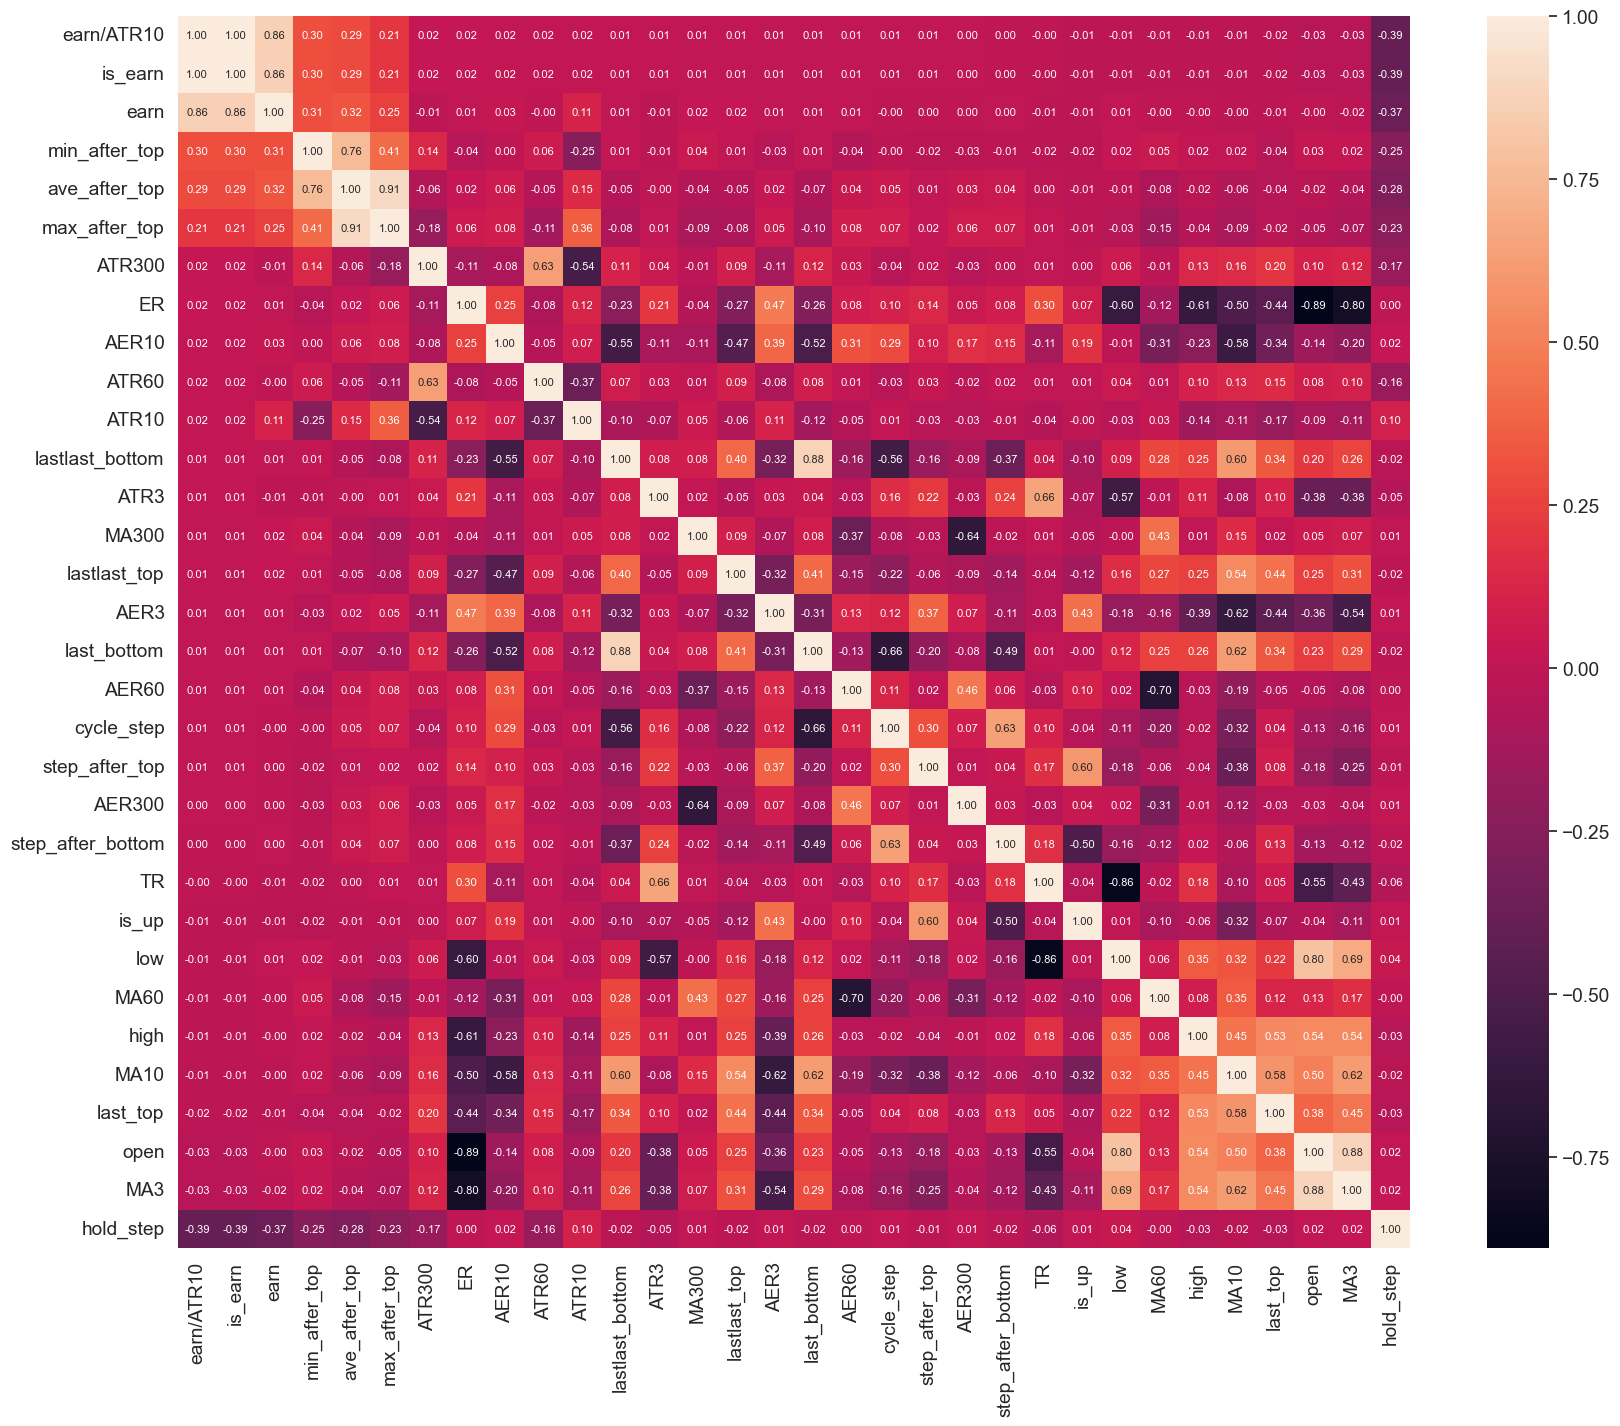

In [81]:
heatmap_data = full_data.df.iloc[:, :].copy()

target.reset_target(3)
target.drop_others(heatmap_data)
drop_col(heatmap_data, [target.target_name()])

base_atr = 'ATR10'

heatmap_data['earn/ATR10'] = heatmap_data['earn'] / heatmap_data['ATR10']
# heatmap_data['max_after_top'] = heatmap_data['max_after_top'] / heatmap_data['ATR60']

for feat in price_feats:
    heatmap_data[feat] = (heatmap_data[feat] - 1) / heatmap_data[base_atr]

for feat in dprice_feats:
    heatmap_data[feat] = heatmap_data[feat] / heatmap_data[base_atr]

for feat in (tr_feats - {base_atr}):
    heatmap_data[feat] = heatmap_data[feat] / heatmap_data[base_atr]

# for feat in (vol_feats - {'AQAV60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AQAV60']

# for feat in (voltr_feats - {'AVT60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AVT60']
    
# for feat in (tn_feats - {'AT60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AT60']


heatmap_data.replace([np.inf, -np.inf], np.nan, inplace=True)
heatmap_data.dropna(axis=0, how='any', inplace=True)

# drop_col(heatmap_data, price_feats - {max_100, min_100})
# drop_col(heatmap_data, dprice_feats)
# drop_col(heatmap_data, tr_feats)
drop_col(heatmap_data, tn_feats)
# drop_col(heatmap_data, vol_feats)
# drop_col(heatmap_data, set(full_data.cols_of_features([FeatTypes.OTHERS])))

heatmap_data['ave_after_top'] = (heatmap_data['max_after_top'] + heatmap_data['min_after_top']) / 2
target_name = 'earn/ATR10'
# max_loss_idx = heatmap_data[heatmap_data['earn/ATR60'] < -0.5001].index
# print(len(max_loss_idx))

heatmap_font(heatmap_data.iloc[:, :].loc[:, :], target=target_name)

up_idx = heatmap_data[heatmap_data['is_up'] == 1].index
down_idx = heatmap_data[heatmap_data['is_up'] == 0].index
drop_col(heatmap_data, ['is_up'])

In [43]:
# up_loss_idx = [idx for idx in max_loss_idx if idx in up_idx]
# print(len(up_loss_idx))
# heatmap_font(heatmap_data.loc[up_idx, :], target=target_name)
# heatmap_data.loc[up_loss_idx].head()

In [42]:
# down_loss_idx = [idx for idx in max_loss_idx if idx in down_idx]
# print(len(down_loss_idx))
# heatmap_font(heatmap_data.loc[down_idx, :], target=target_name)
# heatmap_data.loc[down_loss_idx].head()

In [69]:
full_data.df.head(10)

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,hold_step,earn,earn_after_3,is_earn,max_after_top,min_after_top,ER,lastlast_top,lastlast_bottom,MA3,MA10,MA60,MA300,ATR3,ATR10,ATR60,ATR300,AER3,AER10,AER60,AER300
308,0.999625,1.000095,0.999625,0.000470,1.000111,3.0,0.999065,5.0,0.0,2.0,0.0,0.000222,0.000473,1,0.000694,0.000256,0.798278,1.001589,0.999065,0.999787,0.999876,1.000600,0.998485,0.000420,0.000443,0.000532,0.000769,-0.059068,-0.045474,0.016830,0.021560
348,1.000175,1.000176,0.999790,0.000386,1.000646,8.0,0.999842,11.0,0.0,3.0,1.0,0.000198,0.000080,1,0.000210,-0.000726,-0.454336,1.000646,0.999842,1.000023,1.000211,1.000882,1.000074,0.000309,0.000394,0.000507,0.000721,-0.171409,-0.044804,-0.002931,0.002948
354,0.999455,1.000123,0.999396,0.000726,1.000246,4.0,0.999181,6.0,0.0,2.0,1.0,0.000236,0.001051,1,0.000917,-0.000112,0.750086,1.000246,0.999181,0.999625,0.999630,1.000141,0.999514,0.000477,0.000470,0.000512,0.000715,0.249860,0.075263,0.016527,0.012034
367,1.000084,1.000186,0.999882,0.000304,1.000315,4.0,0.998192,15.0,0.0,11.0,0.0,0.000205,0.001540,1,0.001650,0.000180,-0.275026,1.000315,0.998192,1.000043,1.000070,0.999228,0.998689,0.000302,0.000409,0.000518,0.000696,0.039233,0.100199,0.073933,0.020512
388,0.999757,1.000129,0.999607,0.000522,1.000132,7.0,0.999588,5.0,1.0,2.0,3.0,0.000229,-0.000089,1,0.000039,-0.000423,0.465955,1.000132,0.999588,0.999832,0.999783,0.999930,0.999640,0.000589,0.000457,0.000514,0.000696,0.013254,0.069494,0.034584,0.018517
412,0.999934,1.000067,0.999718,0.000350,1.000156,6.0,0.999501,3.0,1.0,3.0,2.0,0.000217,0.000419,1,0.000338,-0.000300,0.187798,1.000156,0.999503,0.999905,0.999885,0.999959,0.999655,0.000330,0.000433,0.000481,0.000672,0.268323,-0.037545,0.081986,0.031467
421,0.999429,1.000181,0.999061,0.001120,1.000279,5.0,0.998971,12.0,0.0,7.0,0.0,0.000242,0.000499,1,0.000287,-0.000173,0.509955,1.000279,0.998971,0.999622,0.999574,0.999484,0.999312,0.000533,0.000484,0.000474,0.000663,0.185427,0.105602,0.049061,0.037342
463,0.999310,1.000000,0.999246,0.000754,1.000060,6.0,0.997838,5.0,1.0,1.0,0.0,0.000397,0.000758,1,0.000988,0.000295,0.915051,1.000060,0.997838,0.999511,0.999265,1.001609,1.003118,0.000668,0.000792,0.000658,0.000641,0.434853,-0.000855,-0.036366,0.016691
502,0.999655,1.000000,0.999567,0.000433,1.000086,7.0,0.997393,4.0,1.0,3.0,2.0,0.000428,0.000302,1,0.001012,-0.000145,0.796964,1.000086,0.997393,0.999682,0.999163,1.001300,1.005245,0.000492,0.000854,0.000973,0.000631,0.615230,0.241347,0.004366,0.009559
529,0.999086,1.000250,0.998837,0.001413,1.000982,3.0,0.997690,10.0,0.0,7.0,0.0,0.000535,0.001596,1,0.001390,0.000205,0.646983,1.003532,0.997690,0.999390,0.999946,1.002025,1.006848,0.001311,0.001070,0.001005,0.000658,0.110038,0.224862,-0.021879,0.005902


In [68]:
heatmap_data.head(10)

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,cycle_step,hold_step,earn,is_earn,max_after_top,min_after_top,ER,lastlast_top,lastlast_bottom,MA3,MA10,MA60,MA300,ATR3,ATR10,ATR60,ATR300,AER3,AER10,AER60,AER300,earn/ATR10,ave_after_top
308,-0.847295,0.214028,-0.847295,1.061403,0.250100,3.0,-2.110621,5.0,2.0,0.0,0.000222,1,0.000694,0.000256,0.798278,3.587174,-2.110621,-0.479893,-0.280882,1.355685,-3.420933,0.948911,0.000443,1.201229,1.735383,-0.059068,-0.045474,0.016830,0.021560,0.501089,0.000475
348,0.444585,0.445487,-0.532961,0.978537,1.640364,8.0,-0.401299,11.0,3.0,1.0,0.000198,1,0.000210,-0.000726,-0.454336,1.640364,-0.401299,0.058316,0.534313,2.238961,0.189052,0.784351,0.000394,1.285613,1.828548,-0.171409,-0.044804,-0.002931,0.002948,0.501224,-0.000258
354,-1.158435,0.260535,-1.283794,1.544404,0.523335,4.0,-1.742184,6.0,2.0,1.0,0.000236,1,0.000917,-0.000112,0.750086,0.523335,-1.742184,-0.796959,-0.785833,0.299678,-1.032830,1.014524,0.000470,1.089677,1.521072,0.249860,0.075263,0.016527,0.012034,0.501025,0.000403
367,0.204453,0.453955,-0.289353,0.743394,0.769297,4.0,-4.415663,15.0,11.0,0.0,0.000205,1,0.001650,0.000180,-0.275026,0.769297,-4.415663,0.105981,0.171706,-1.886396,-3.202232,0.738485,0.000409,1.263811,1.700439,0.039233,0.100199,0.073933,0.020512,0.501178,0.000915
388,-0.531791,0.282587,-0.858629,1.141293,0.288021,7.0,-0.902104,5.0,2.0,3.0,0.000229,1,0.000039,-0.000423,0.465955,0.288021,-0.902104,-0.368243,-0.474963,-0.154181,-0.788065,1.288021,0.000457,1.123567,1.522604,0.013254,0.069494,0.034584,0.018517,0.501055,-0.000192
412,-0.151764,0.155045,-0.652994,0.808121,0.361772,6.0,-1.153404,3.0,3.0,2.0,0.000217,1,0.000338,-0.000300,0.187798,0.361772,-1.148482,-0.219305,-0.266038,-0.094463,-0.798285,0.763549,0.000433,1.112893,1.554687,0.268323,-0.037545,0.081986,0.031467,0.501115,0.000019
421,-1.181258,0.373955,-1.942367,2.316395,0.577797,5.0,-2.127145,12.0,7.0,0.0,0.000242,1,0.000287,-0.000173,0.509955,0.577797,-2.127145,-0.780662,-0.880701,-1.067569,-1.422985,1.102141,0.000484,0.979836,1.371355,0.185427,0.105602,0.049061,0.037342,0.500997,0.000057
463,-0.871244,0.000000,-0.952082,0.952126,0.075448,6.0,-2.728702,5.0,1.0,0.0,0.000397,1,0.000988,0.000295,0.915051,0.075448,-2.728702,-0.617506,-0.927292,2.031107,3.935681,0.842697,0.000792,0.829920,0.809112,0.434853,-0.000855,-0.036366,0.016691,0.500609,0.000642
502,-0.403711,0.000000,-0.506520,0.506561,0.101137,7.0,-3.052491,4.0,3.0,2.0,0.000428,1,0.001012,-0.000145,0.796964,0.101137,-3.052491,-0.371949,-0.979397,1.521474,6.141331,0.575797,0.000854,1.139725,0.739271,0.615230,0.241347,0.004366,0.009559,0.500565,0.000434
529,-0.854687,0.234161,-1.086840,1.321034,0.918244,3.0,-2.159296,10.0,7.0,0.0,0.000535,1,0.001390,0.000205,0.646983,3.302335,-2.159296,-0.570126,-0.050947,1.893278,6.402113,1.225251,0.001070,0.939720,0.615488,0.110038,0.224862,-0.021879,0.005902,0.500451,0.000797


In [11]:
temp = heatmap_data[(heatmap_data['ATR60'] > 0.0) & (heatmap_data['ATR60'] <= 0.000334)]
print(len(temp))
# histplot(temp['max_after_top'])
for delta in np.arange(0.2, 1.5, 0.1): 
    earn_rate = sum(temp['max_after_top'] > delta) / len(temp)
    print(f"{delta :.1f}:  rate: {earn_rate*100 :.2f}%, ave earn: {2 * delta * (earn_rate - 0.5):.5f}")

171
0.2:  rate: 88.30%, ave earn: 0.15322
0.3:  rate: 82.46%, ave earn: 0.19474
0.4:  rate: 77.78%, ave earn: 0.22222
0.5:  rate: 75.44%, ave earn: 0.25439
0.6:  rate: 73.68%, ave earn: 0.28421
0.7:  rate: 71.35%, ave earn: 0.29883
0.8:  rate: 69.59%, ave earn: 0.31345
0.9:  rate: 67.25%, ave earn: 0.31053
1.0:  rate: 66.67%, ave earn: 0.33333
1.1:  rate: 64.33%, ave earn: 0.31520
1.2:  rate: 61.40%, ave earn: 0.27368
1.3:  rate: 59.06%, ave earn: 0.23567
1.4:  rate: 56.73%, ave earn: 0.18830


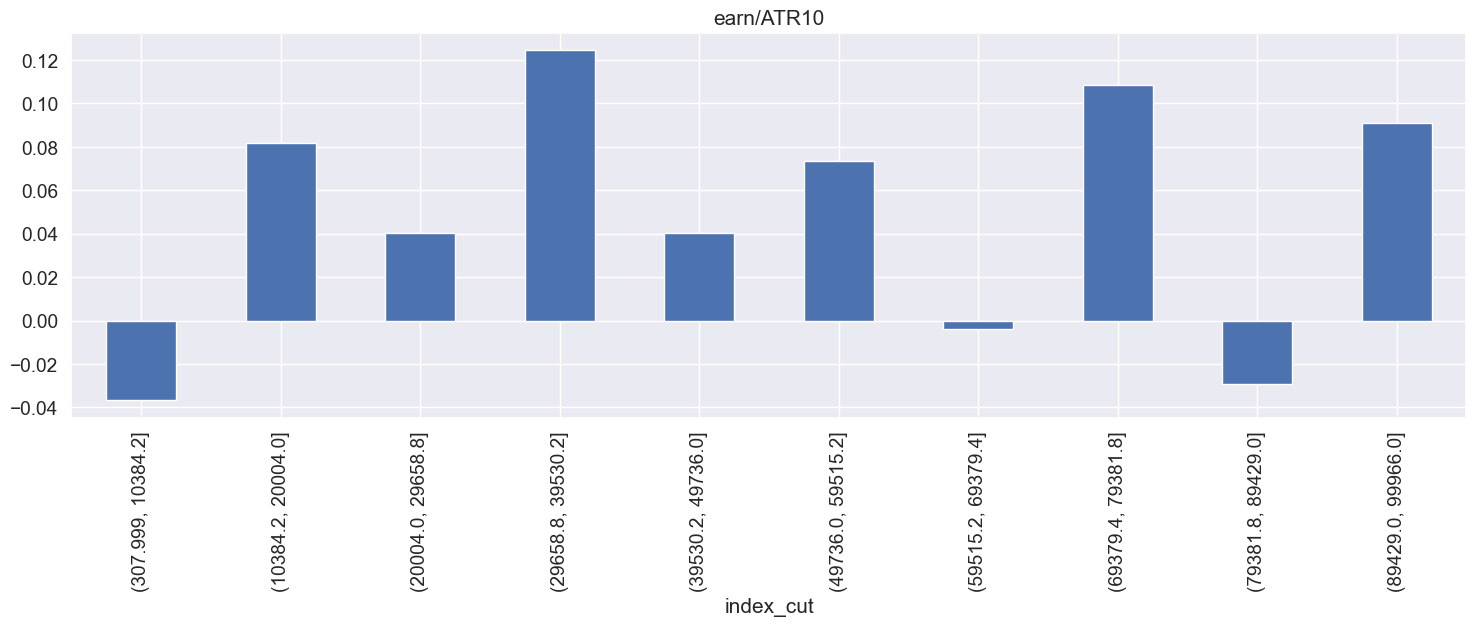

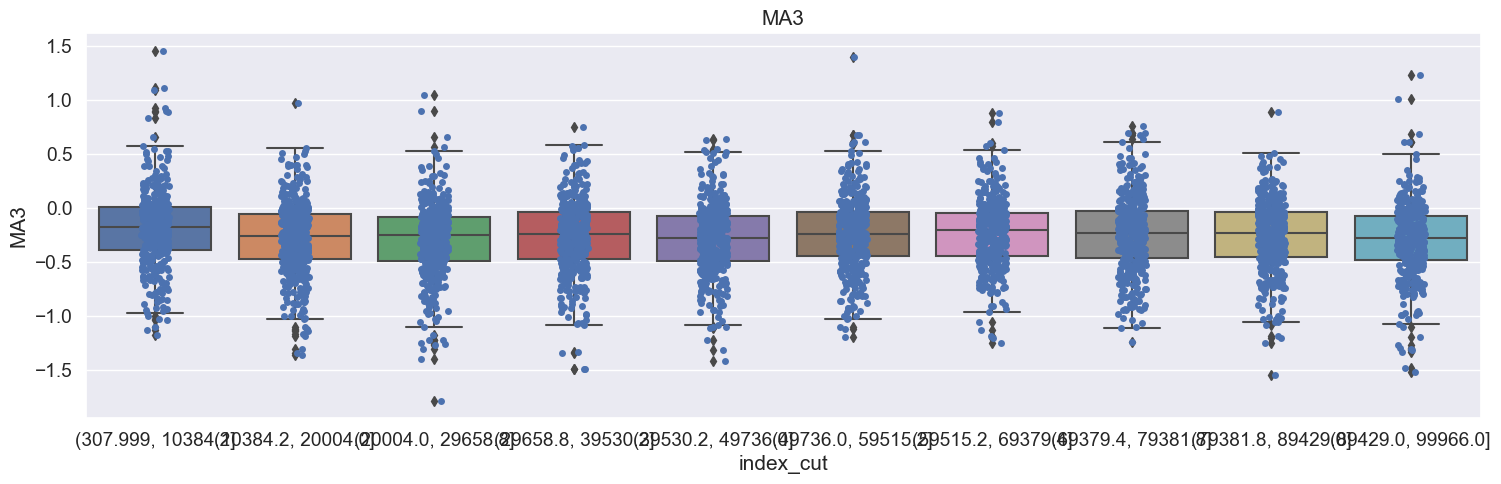

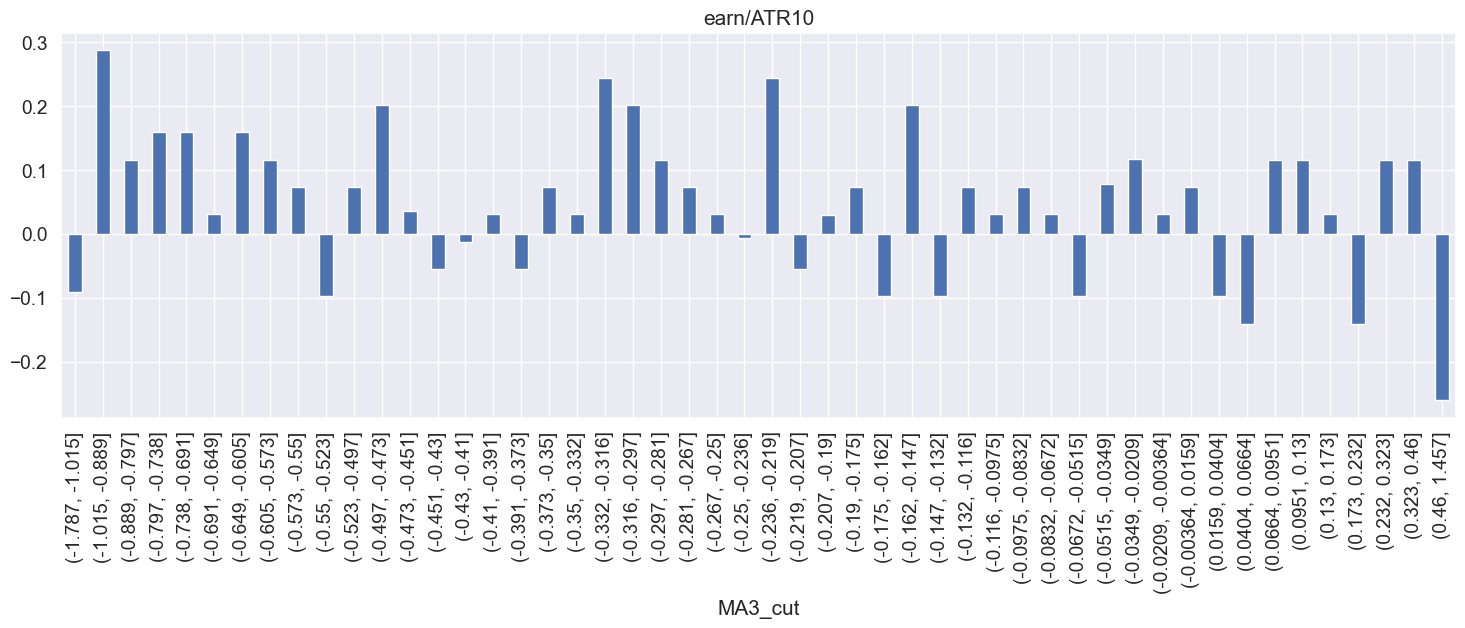

In [84]:

plot_data = heatmap_data.loc[:, :].copy()
plot_data['index'] = plot_data.index
checked = 'MA3'
bias = 0

# plt_A_B(plot_data, 'index', 'ATR10', cut_num=10)
plt_A_B(plot_data, 'index', 'earn/ATR10', cut_num=10)
# plt_A_B(plot_data, 'index', 'ATR10', cut_num=10)

# plt_A_B(plot_data, 'index', checked, cut_num=10, bias=bias)
plt_box_A_B(plot_data, 'index', checked, cut_num=10)

plt_A_B(plot_data, checked, target_name, cut_num=50)
# plt_box_A_B(plot_data, checked, target_name, cut_num=10)

In [78]:
heatmap_data[heatmap_data['MA3'] >= 0.46]

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,cycle_step,hold_step,earn,is_earn,max_after_top,min_after_top,ER,lastlast_top,lastlast_bottom,MA3,MA10,MA60,MA300,ATR3,ATR10,ATR60,ATR300,AER3,AER10,AER60,AER300,earn/ATR10,ave_after_top
1226,0.801435,0.893867,-0.201174,1.095096,1.109178,5.0,-2.150935,7.0,2.0,1.0,0.000330,1,0.001017,-0.000004,-0.731841,1.109178,-2.150935,0.546977,0.444324,1.399023,1.284124,0.663930,0.000659,1.338716,1.105907,0.000263,-0.007655,0.019266,0.021425,0.500731,0.000507
1470,1.458087,1.542532,-0.316388,1.858977,2.050329,4.0,-0.753251,8.0,4.0,33.0,-0.001902,0,0.000028,-0.000859,-0.784349,2.050329,-0.753251,1.096849,1.040984,2.794273,-3.118336,1.038357,0.000633,0.990702,1.374051,-0.228432,0.072809,-0.005073,0.029604,-3.004570,-0.000415
1739,0.511539,0.840806,-0.373365,1.214317,1.856534,4.0,-0.074967,8.0,4.0,0.0,0.000122,1,0.000452,-0.001106,-0.421257,1.856534,-0.074967,0.573766,0.741879,1.706723,5.602744,0.843892,0.000243,2.504336,2.391592,-0.249430,-0.117573,-0.085242,-0.023431,0.501985,-0.000327
2140,1.605613,1.605613,-0.742580,2.348317,2.607724,5.0,0.935055,7.0,2.0,1.0,0.000144,1,0.000788,-0.000082,-0.683729,2.607724,0.935055,1.114698,1.984602,1.907467,3.066522,1.170702,0.000287,1.146736,1.321168,-0.009619,-0.013363,0.034771,-0.006966,0.501678,0.000353
3423,0.665428,0.825874,-0.005067,0.831110,1.511569,3.0,-0.717784,9.0,6.0,2.0,-0.000639,0,0.000064,-0.000795,-0.800650,2.766425,-0.717784,0.529190,0.481844,-2.956088,-2.529623,0.851376,0.000212,1.354698,1.560463,-0.338269,-0.026459,0.024432,0.005990,-3.013642,-0.000365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91905,1.630725,1.669588,-0.340623,2.010287,2.959689,6.0,1.440219,4.0,2.0,0.0,0.000249,1,0.001522,-0.000302,-0.811190,2.959689,1.440219,1.234982,1.746704,3.839391,4.055046,1.049633,0.000497,1.001626,1.012965,-0.606297,-0.142862,-0.090906,-0.049305,0.500967,0.000610
92967,0.369018,0.486374,-0.169514,0.656018,2.257139,6.0,0.760203,8.0,2.0,4.0,0.000145,1,0.000017,-0.000330,-0.562512,2.257139,0.760203,0.496805,1.058678,1.921741,0.451489,0.848133,0.000290,1.168101,1.816751,-0.303282,-0.169420,-0.030052,0.005328,0.501662,-0.000156
97157,0.801045,1.355391,-0.466551,1.822014,1.935133,5.0,0.165433,8.0,3.0,1.0,0.000267,1,0.000626,-0.001117,-0.439648,1.935133,0.165433,0.684951,0.987593,2.414381,7.389554,1.210347,0.000534,1.212669,1.698621,-0.249589,-0.026650,0.021025,-0.003882,0.500900,-0.000245
97397,0.956811,1.063727,-0.434914,1.498701,1.749924,10.0,-1.034733,5.0,5.0,6.0,0.000321,1,0.000237,-0.000487,-0.638427,1.749924,-1.034733,0.608678,0.823558,2.191614,1.420904,0.956066,0.000641,0.775113,0.857346,-0.195917,0.037378,-0.013820,0.018754,0.500750,-0.000125


In [35]:
# heatmap_data['ATR10'].mean()
heatmap_data['AER10'].mean()

0.25180949334818037

In [30]:
get_sell_atr = lambda x: 1 - (x - 0.000260) / (0.00228 - 0.000260) * 0.5
get_sell_atr(0.000130)

1.0321782178217822

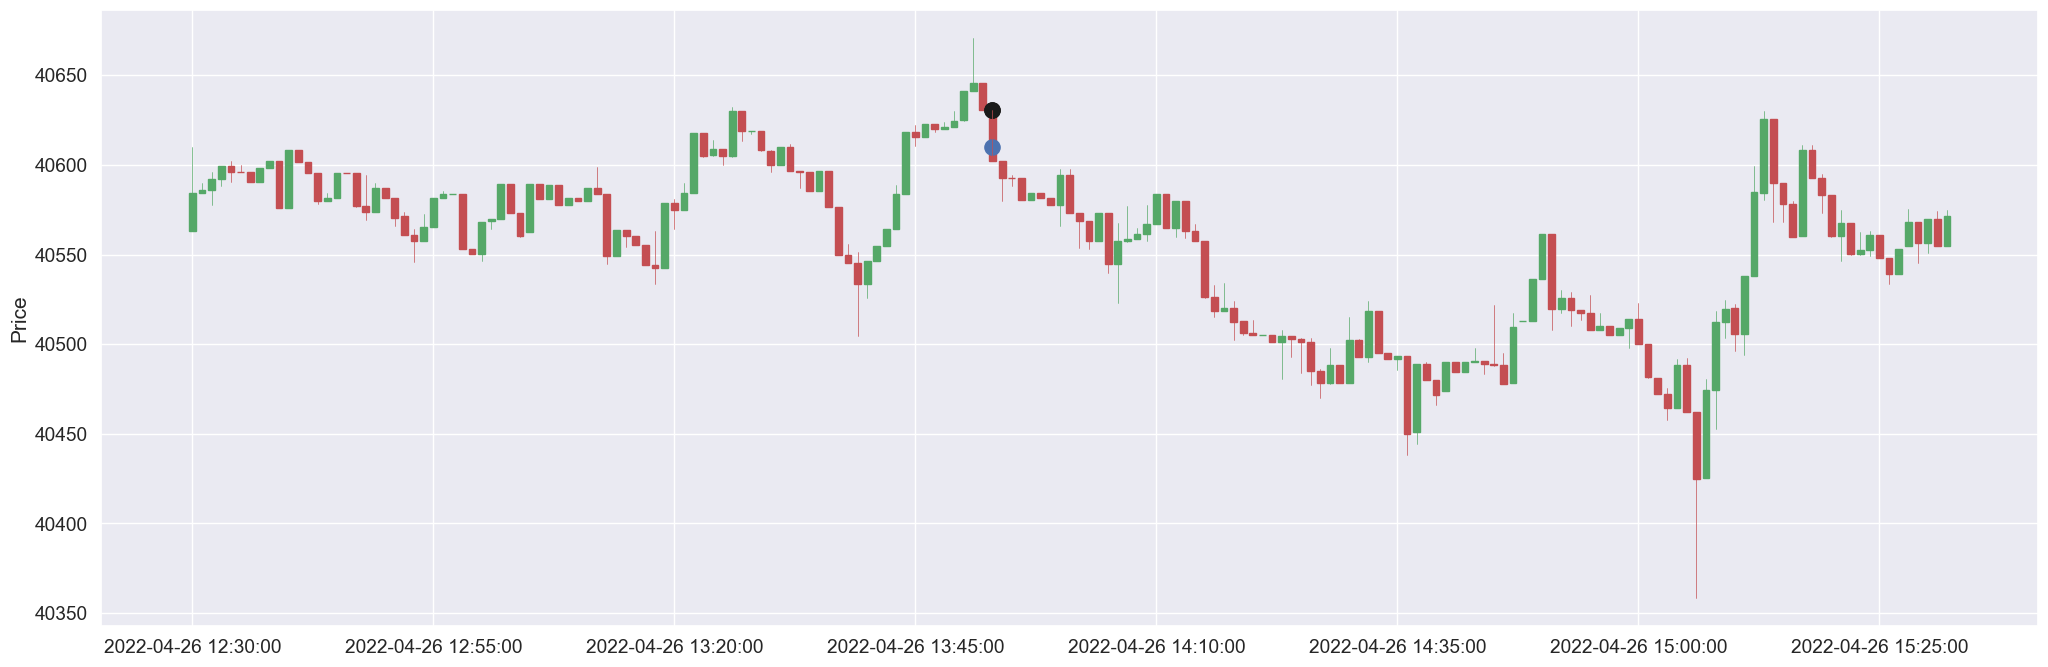

In [13]:
# idx = heatmap_data[(heatmap_data['high'] > 0.4)].index
# print(len(idx))
# 150765 有问题！！！
start = 150765      
# print(f"high: {heatmap_data.loc[start, 'earn/ATR60']}")
last_top_idx = start - sim_data.loc[start, 'step_after_top']
sell_idx = sim_data.loc[start, 'hold_step'] + start + 1
points = [PricePlot.Points(start+1, sim_data.loc[start, 'last_top'], s=120, c='b', label='default'),
          PricePlot.Points(sell_idx, sim_data.loc[start, 'sell_price'], s=120, c='k', label='default'),
          PricePlot.Points(start+1, sim_data.loc[start, 'buy_price'], s=120, c='k', label='default')]
plot(sim_data, last_top_idx, start+100, points)

In [66]:
heatmap_data[heatmap_data['AER10'] > 0.4]

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,cycle_step,hold_step,earn,is_earn,max_after_top,min_after_top,ER,lastlast_top,lastlast_bottom,MA3,MA10,MA60,MA300,ATR3,ATR10,ATR60,ATR300,AER3,AER10,AER60,AER300,earn/ATR10,ave_after_top
5916,-0.563238,0.180649,-0.563238,0.743908,0.310866,3.0,-4.844257,10.0,7.0,14.0,-0.002572,0,0.000109,-0.002011,0.757134,-4.303962,-4.844257,-0.537883,-2.321593,-4.985972,-6.510988,1.188848,0.001714,0.402675,0.246243,0.250085,0.448643,0.050170,0.017125,-1.500844,-0.000951
16422,0.093853,0.608970,-0.320963,0.930004,0.645508,3.0,-4.475570,10.0,7.0,2.0,0.000233,1,0.000271,-0.000261,-0.100917,-2.223814,-4.475570,0.031762,-1.056455,-1.341166,13.861365,0.734656,0.000465,1.267051,1.528524,0.044293,0.405142,0.017114,-0.002235,0.501039,0.000005
18077,-1.288129,0.169988,-1.290018,1.460100,2.993673,27.0,-5.116630,9.0,18.0,0.0,0.000179,1,0.000376,-0.001230,0.882220,2.993673,-5.116630,-1.138918,-3.221645,-3.219300,-11.691305,1.420122,0.000358,1.492791,1.565049,0.858768,0.432478,0.089521,0.064085,0.501350,-0.000427
36032,-0.331741,0.143300,-0.542229,0.685581,0.478715,13.0,-4.922051,9.0,4.0,0.0,0.000322,1,0.000693,-0.000060,0.483883,0.478715,-4.922051,-0.530856,-2.052753,-1.075044,-9.517801,1.026945,0.000642,1.481917,1.475424,0.419707,0.400749,0.008395,0.042138,0.500752,0.000316
36944,-0.987664,0.000757,-1.142057,1.142890,0.267918,15.0,-5.133581,10.0,5.0,0.0,0.000233,1,0.000239,-0.001075,0.864181,0.267918,-5.133581,-0.647342,-1.741240,2.511163,-10.945241,0.826787,0.000465,1.139623,1.374061,0.142713,0.447838,-0.072717,0.029505,0.501037,-0.000418
71254,-0.279886,0.212871,-0.393220,0.606189,0.477974,5.0,-5.529713,12.0,7.0,0.0,0.000194,1,0.000343,-0.000418,0.461714,0.477974,-5.529713,-0.415229,-1.187642,-2.293683,-0.395605,0.851582,0.000387,1.380572,1.908390,0.285357,0.404085,0.041236,-0.008251,0.501242,-0.000037
